# Geometric Position of InSAR Points

@author: Max Felius

## Researching the Predictions
Using the 'Point Geometry Package' developed in the notebook 'Methodology_Point_Geometry'.

### Predictions
- Case 1: Less points will provide a worse fit.
- Case 2: Less simulation will provide a more volatile solution
- Case 3: Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Case 4: Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- Case 5: The further the points away from the center, the worse the fit will be.
- Case 6: Very heterogenous points will provide a worse fit
- Case 7: The more points with the same radius will give worse fit

In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, time
from tqdm import tqdm
import random

#import package
sys.path.extend(os.path.join(os.getcwd(),'Point_Geometry_Package'))

from Point_Geometry_Package.get_random_subsamples import get_random_subsamples
from Point_Geometry_Package.simulate_sinkhole_parameter_retrieval import simulate_sinkhole_parameter_retrieval

### Define Test Sinkhole Parameters

In [2]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195 
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#Define the sinkhole grid
n = 100
x_range = R_wink2016_gaus
y_range = R_wink2016_gaus
x = np.linspace(x0-x_range,x0+x_range,n)
y = np.linspace(y0-y_range,y0+y_range,n)

#creat x/y grid
xv, yv = np.meshgrid(x,y)

#unravel the grids
x_unravel = xv.ravel()
y_unravel = yv.ravel()

#other parameters
max_subs = 100
n_sims = 100

### Case 1: Less Points will Provide a worse fit

In [3]:
fit_total_save, cond_number_total_save, number_subs = \
simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel,v_wink2016_gaus,R_wink2016_gaus)

Simulating:   1%|▋                                                                  | 1/100 [00:03<05:26,  3.30s/it]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:47: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:   4%|██▋                                                                | 4/100 [00:13<05:15,  3.29s/it]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Mo

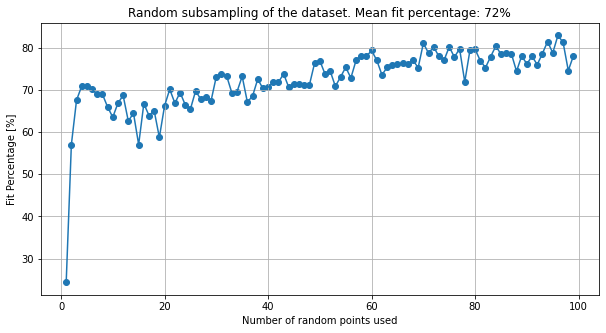

In [4]:
#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,avg_data)
plt.scatter(number_subs,avg_data)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.mean(avg_data)

plt.title('Random subsampling of the dataset. Mean fit percentage: {:.0f}%'.format(mean))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

#### Conclusions
- Less number of points will provide a worse fit. The increase in points provides an increase in Fit Percentage.

### Case 2

Less simulations will provide a more volatile solution (bigger variance).

Simulating:   0%|                                                                            | 0/20 [00:00<?, ?it/s]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:47: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:  25%|█████████████████                                                   | 5/20 [00:19<00:58,  3.89s/it]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Mo

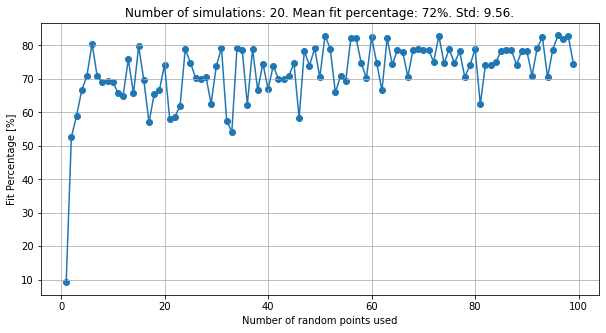

In [5]:
n_sims = 20

fit_total_save, cond_number_total_save, number_subs = \
simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel,v_wink2016_gaus,R_wink2016_gaus)

#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,avg_data)
plt.scatter(number_subs,avg_data)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.mean(avg_data)
std = np.std(avg_data)
plt.title('Number of simulations: {:02d}. Mean fit percentage: {:.0f}%. Std: {:.02f}.'.format(n_sims,mean,std))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

Simulating:   1%|▋                                                                  | 1/100 [00:03<05:47,  3.51s/it]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
Simulating:   2%|█▎                                                                 | 2/100 [00:07<05:47,  3.55s/it]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:47: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:  14%|█████████▏                          

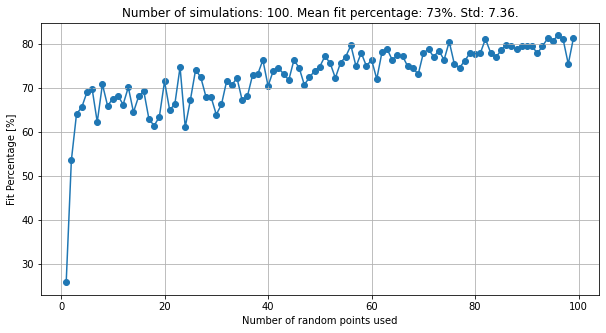

In [6]:
n_sims = 100

fit_total_save, cond_number_total_save, number_subs = \
simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel,v_wink2016_gaus,R_wink2016_gaus)

#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,avg_data)
plt.scatter(number_subs,avg_data)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.mean(avg_data)
std = np.std(avg_data)
plt.title('Number of simulations: {:02d}. Mean fit percentage: {:.0f}%. Std: {:.02f}.'.format(n_sims,mean,std))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

#### Conclusions
- Using more simulations will provide a solution with a lower variance

### Case 3
Higher model fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).

In [ ]:
n_sims = 100

fit_total_save, cond_number_total_save, number_subs = \
simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel,v_wink2016_gaus,R_wink2016_gaus)

avg_cond = np.median(cond_number_total_save,axis=0)

#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

Median conditional number: 7.33.
Mean Model fit: 72.93%.


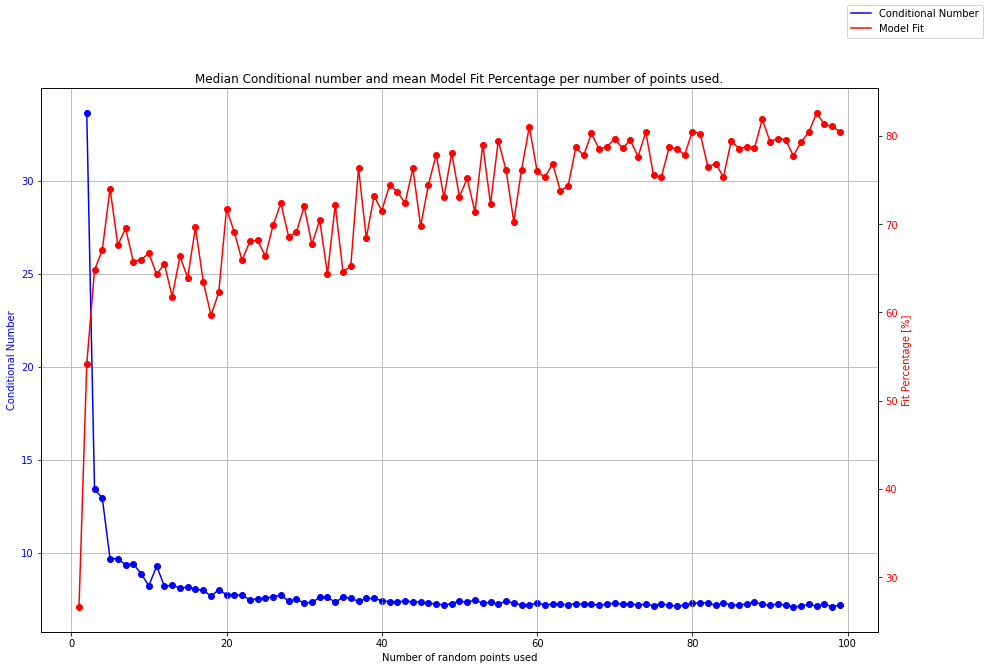

In [11]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(number_subs[1:],avg_cond[1:],c='b',label='Conditional Number')
ax1.scatter(number_subs[1:],avg_cond[1:],c='b')

ax1.set_title('Median Conditional number and mean Model Fit Percentage per number of points used.')
ax1.set_ylabel('Conditional Number',color='b')
ax1.set_xlabel('Number of random points used')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Fit Percentage [%]',color='r')
ax2.plot(number_subs,avg_data,c='r',label='Model Fit')
ax2.scatter(number_subs,avg_data,c='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()
ax1.grid(True);

print('Median conditional number: {:.02f}.'.format(np.median(avg_cond)))
print('Mean Model fit: {:.02f}%.'.format(np.mean(avg_data)))

#### Conclusion
- The higher the model fit percentage the lower the conditional number.
- The conditional number will converge to a specific value and not to zero or one.

### Case 4

Points on a line or spread out on a 2D plane won't affect the fit and conditional number.

In [4]:
def zg(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))

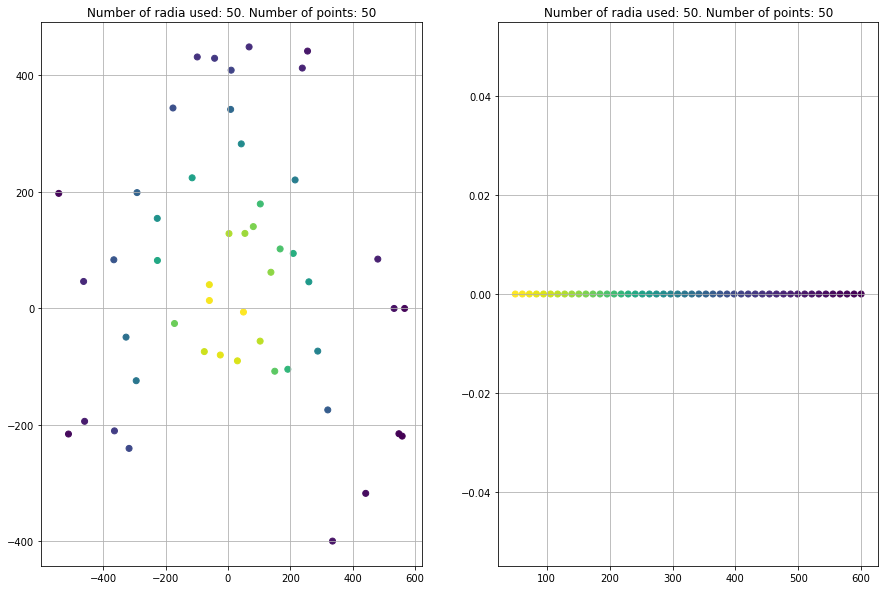

In [5]:
# Point on a circle with the same r
R_circ = 600
n_circ = 50
theta = np.deg2rad(np.linspace(10,360,n_circ))
num_r = 50
r_array_circ = np.linspace(50,R_circ,num_r)

#total number of points is nxn

x_circ = np.array([])
y_circ = np.array([])
z_circ = np.array([])

for item in r_array_circ:
    x_item = item*np.cos(theta)
    y_item = item*np.sin(theta)
    idx = random.sample(range(0,len(x_item)),1)
    x_circ = np.concatenate((x_circ,x_item[idx]))
    y_circ = np.concatenate((y_circ,y_item[idx]))
    r = np.sqrt((x_item**2)+(y_item**2))
    z_circ = np.concatenate((z_circ,zg(R_circ,r)[idx]))

x_line = np.array([])
y_line = np.array([])
z_line = np.array([])

n_line = num_r

phi = np.deg2rad(np.arange(0,90*n_line,90))

for item in r_array_circ:
    x_item = np.array([item]) #*np.cos(phi)
    y_item = np.array([0]) #np.array([0]*len(phi)) #item*np.sin(phi)
    x_line = np.concatenate((x_line,x_item))
    y_line = np.concatenate((y_line,y_item))
    r = np.sqrt((x_item**2)+(y_item**2))
    z_line = np.concatenate((z_line,zg(R_circ,r)))    
    
#plot the figure
fig, ax = plt.subplots(ncols=2,figsize=(15,10))
h = ax[0].scatter(x_circ,y_circ,c=z_circ)

ax[0].set_title(f'Number of radia used: {num_r}. Number of points: {len(x_circ)}')

# fig.colorbar(h,axis=ax[0])
ax[0].grid(True);

h2= ax[1].scatter(x_line,y_line,c=z_line)
ax[1].set_title(f'Number of radia used: {num_r}. Number of points: {len(x_line)}')
ax[1].grid(True);

In [6]:
max_subs = 40
n_sims_circ = 20

assert max_subs < n_circ, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims_circ
f = x_circ #x_unravel
g = y_circ #y_unravel

#the sinkhole is predefined
fit_total_save_circ, cond_number_total_save_circ, number_subs_circ = \
simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g,v_wink2016_gaus,R_wink2016_gaus)

Simulating:  30%|████████████████████▍                                               | 6/20 [00:03<00:09,  1.41it/s]H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:63: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
H:\My Documents\Master_Thesis\Lagrangian_Kinematic_Model\Point_Geometry\Point_Geometry_Package\case_inverse_kinematic_model.py:47: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


In [7]:
max_subs = 40
n_sims_circ = 20

assert max_subs < n_circ, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims_circ
f = x_line #x_unravel
g = y_line #y_unravel

#the sinkhole is predefined
fit_total_save_line, cond_number_total_save_line, number_subs_line = \
simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g,v_wink2016_gaus,R_wink2016_gaus)

Simulating: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20it/s]


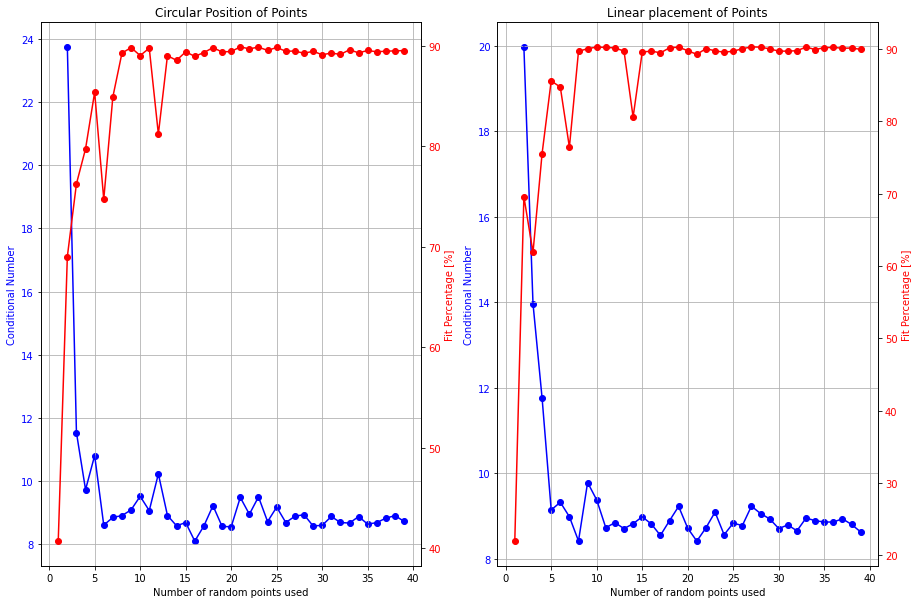

In [10]:
avg_cond_circ = np.median(cond_number_total_save_circ,axis=0)
avg_data_circ = np.sum(fit_total_save_circ,axis=0)/n_sims_circ

ccc = 30000
avg_cond_circ[avg_cond_circ>ccc] = ccc

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(15,10))

ax1.plot(number_subs_circ[1:],avg_cond_circ[1:],c='b',label='Conditional Number')
ax1.scatter(number_subs_circ[1:],avg_cond_circ[1:],c='b')
# ax1.set_title('Median Conditional number and Model Fit Percentage per number of points used.')
ax1.set_title('Circular Position of Points')
ax1.set_ylabel('Conditional Number',color='b')
ax1.set_xlabel('Number of random points used')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Fit Percentage [%]',color='r')
ax2.plot(number_subs_circ,avg_data_circ,c='r',label='Model Fit')
ax2.scatter(number_subs_circ,avg_data_circ,c='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.grid(True)

# fig.legend()3.grid(True);

#line figures

avg_cond_line = np.median(cond_number_total_save_line,axis=0)
avg_data_line = np.sum(fit_total_save_line,axis=0)/n_sims_circ
# avg_cond_line[avg_cond_line>700] = 700

ax3.plot(number_subs_line[1:],avg_cond_line[1:],c='b',label='Conditional Number')
ax3.scatter(number_subs_line[1:],avg_cond_line[1:],c='b')
# ax3.set_title('Median Conditional number and Model Fit Percentage per number of points used.')
ax3.set_title('Linear placement of Points')
ax3.set_ylabel('Conditional Number',color='b')
ax3.set_xlabel('Number of random points used')
ax3.tick_params(axis='y', labelcolor='b')

ax4 = ax3.twinx()

ax4.set_ylabel('Fit Percentage [%]',color='r')
ax4.plot(number_subs_line,avg_data_line,c='r',label='Model Fit')
ax4.scatter(number_subs_line,avg_data_line,c='r')
ax4.tick_params(axis='y', labelcolor='r')

# fig.legend()
ax3.grid(True);

#### Conclusion
- The number of different radia is leading for getting the best fit.

### Case 4

The further the points away from the center, the worse the fit will be.

In [37]:
def create_circular_dataset(num_r,r_filt):
    # Point on a circle with the same r
    R_circ = 600
    n_circ = 360
    theta = np.deg2rad(np.linspace(0,360,n_circ))
#     num_r = 150 #this will influence the number of points generated
    r_array_circ = np.linspace(r_filt,R_circ,num_r)

    #total number of points is nxn

    x_circ = np.array([])
    y_circ = np.array([])
    z_circ = np.array([])
    r_circ = np.array([])

    for item in r_array_circ:
        x_item = item*np.cos(theta)
        y_item = item*np.sin(theta)
        idx = random.sample(range(0,len(x_item)),1)
        x_circ = np.concatenate((x_circ,x_item[idx]))
        y_circ = np.concatenate((y_circ,y_item[idx]))
        r = np.sqrt((x_item**2)+(y_item**2))
        r_circ = np.concatenate((r_circ,r[idx]))
    #     z_circ = np.concatenate((z_circ,zg(R_circ,r)[idx]))
    
    return x_circ, y_circ, r_circ

Investigate 3 cases:
- No Points within a radius of 100 meters
- No Points within a radius of 250 meters
- No Points within a radius of 450 meters

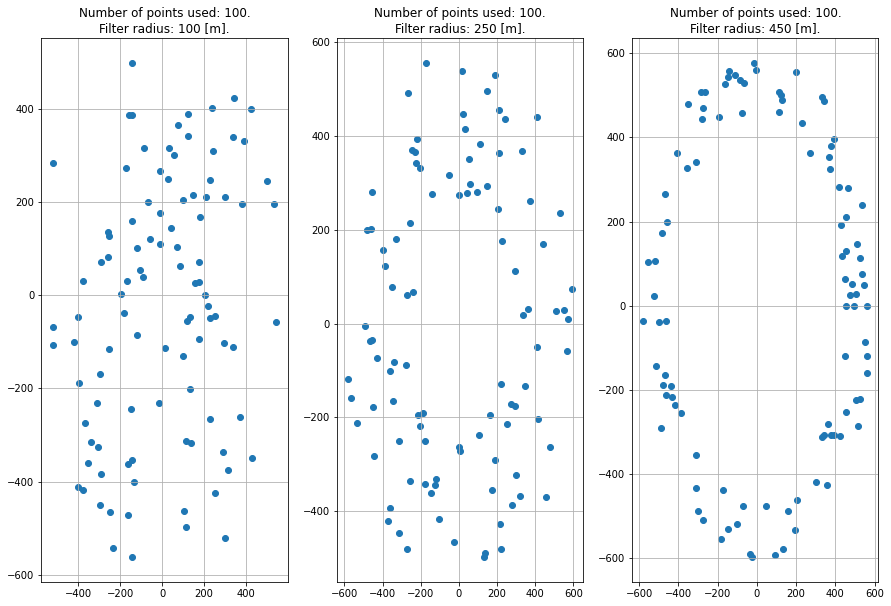

In [40]:
num_r = 100

r_filt1 = 100
r_filt2 = 250
r_filt3 = 450

x_circ1, y_circ1, r_circ1 = create_circular_dataset(num_r,r_filt1)
x_circ2, y_circ2, r_circ2 = create_circular_dataset(num_r,r_filt2)
x_circ3, y_circ3, r_circ3 = create_circular_dataset(num_r,r_filt3)

fig, ax = plt.subplots(ncols=3, figsize=(15,10))

ax[0].scatter(x_circ1,y_circ1)
ax[1].scatter(x_circ2,y_circ2)
ax[2].scatter(x_circ3,y_circ3)

ax[0].set_title(f'Number of points used: {len(x_circ1)}.' + '\n' + f'Filter radius: {r_filt1} [m].')
ax[1].set_title(f'Number of points used: {len(x_circ2)}.' + '\n'+ f'Filter radius: {r_filt2} [m].')
ax[2].set_title(f'Number of points used: {len(x_circ3)}.' + '\n'+ f'Filter radius: {r_filt3} [m].')

ax[0].grid(True);
ax[1].grid(True);
ax[2].grid(True);

In [ ]:
x0 = 0
y0 = 0

max_subs = 
n_sims = 

In [ ]:
# subcase 1
max_subs = 40
n_sims_circ = 20

assert max_subs < num_r, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims
f = x_circ1 #x_unravel
g = y_circ1 #y_unravel

#the sinkhole is predefined
fit_total_save_line, cond_number_total_save_line, number_subs_line = \
simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g,v_wink2016_gaus,R_wink2016_gaus)

In [ ]:
# subcase 2
assert max_subs < num_r, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims
f = x_line #x_unravel
g = y_line #y_unravel

#the sinkhole is predefined
fit_total_save_line, cond_number_total_save_line, number_subs_line = \
simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g,v_wink2016_gaus,R_wink2016_gaus)

In [ ]:
# subcase 3
assert max_subs < num_r, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims
f = x_line #x_unravel
g = y_line #y_unravel

#the sinkhole is predefined
fit_total_save_line, cond_number_total_save_line, number_subs_line = \
simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g,v_wink2016_gaus,R_wink2016_gaus)